# Importing Important Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers


In [2]:
Batch_Size = 32 # 32 images in 1 batch
Channels = 3  # RGB
Image_Size = 256  # 256x256
Epoches = 50  # for training purpose


# Load Training and Validation data

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    batch_size=Batch_Size,
    shuffle=True,
    image_size=(Image_Size, Image_Size)
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "valid",
    batch_size=Batch_Size,
    shuffle=True,
    image_size=(Image_Size, Image_Size)
)


Found 3208 files belonging to 20 classes.
Found 100 files belonging to 20 classes.


# Load Class Names

In [4]:
class_names = train_ds.class_names
for class_name in class_names:
    print(class_name)


ABBOTTS BABBLER
ABBOTTS BOOBY
ABYSSINIAN GROUND HORNBILL
AFRICAN CROWNED CRANE
AFRICAN EMERALD CUCKOO
AFRICAN FIREFINCH
AFRICAN OYSTER CATCHER
AFRICAN PIED HORNBILL
AFRICAN PYGMY GOOSE
ALBATROSS
ALBERTS TOWHEE
ALEXANDRINE PARAKEET
ALPINE CHOUGH
ALTAMIRA YELLOWTHROAT
AMERICAN AVOCET
AMERICAN BITTERN
AMERICAN COOT
AMERICAN FLAMINGO
AMERICAN GOLDFINCH
AMERICAN KESTREL


# IMAGE VISUALIZATION

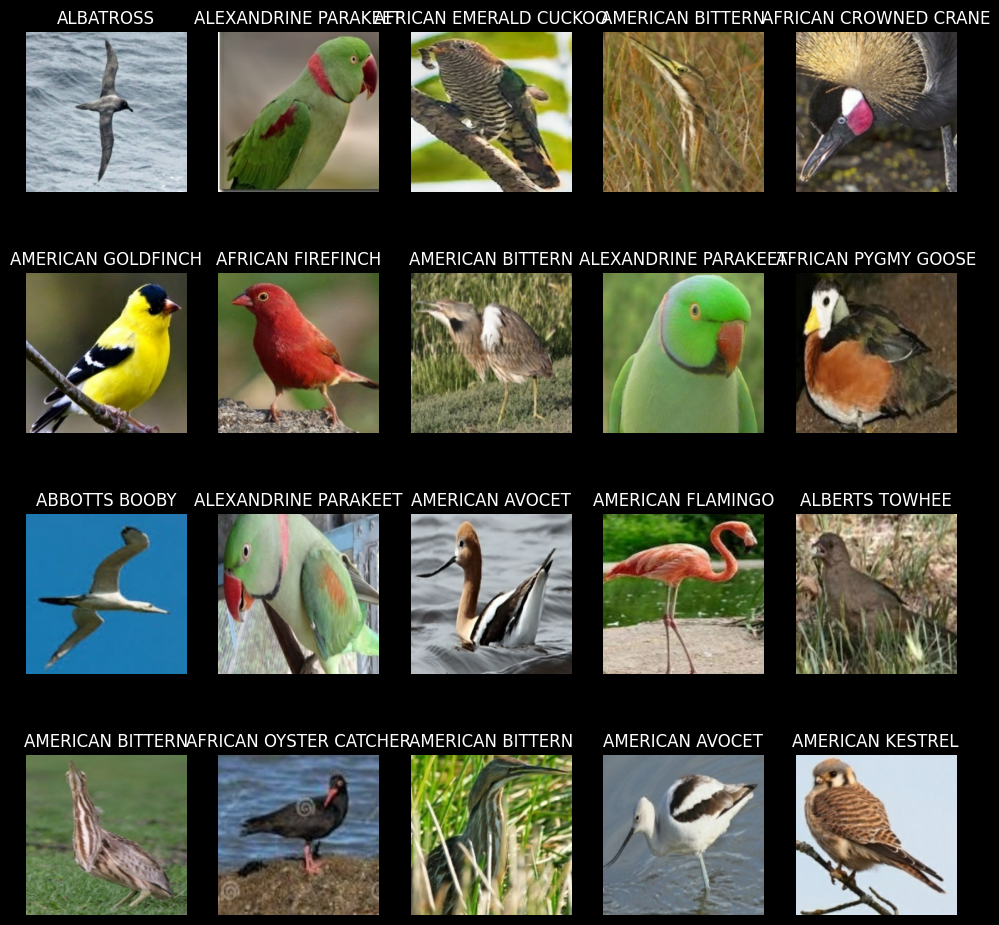

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
plt.show()


In [6]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1./255),
])


# Data Agumentation

In [7]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),  # Add random contrast adjustment
  layers.experimental.preprocessing.RandomZoom(0.2),      # Add random zoom
])


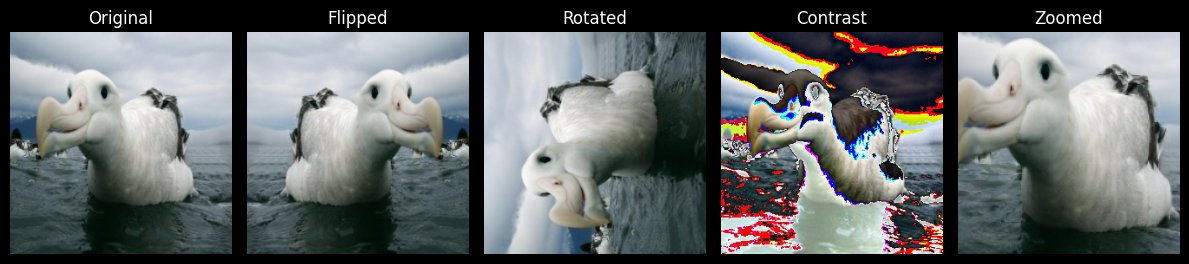

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Select a single image from the dataset
image_index = 1
image = next(iter(train_ds.unbatch().skip(image_index).take(1)))[0]

# Apply different augmentations to the image
flipped_image = tf.image.flip_left_right(image)
rotated_image = tf.image.rot90(image)
contrast_image = tf.image.adjust_contrast(image, 2)  # Increase contrast
zoomed_image = tf.image.central_crop(image, 0.7)     # Zoom into the image

# Plot the original and augmented images
plt.figure(figsize=(12, 4))
titles = ["Original", "Flipped", "Rotated", "Contrast", "Zoomed"]
images = [image, flipped_image, rotated_image, contrast_image, zoomed_image]

for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.title(titles[i], fontsize=12)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

plt.tight_layout()
plt.show()


# ResNet 50

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

def create_resnet50_model(input_shape, num_classes):
    # Load pre-trained ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Combine base model and custom head
    model = Model(inputs=base_model.input, outputs=outputs, name='resnet50_custom')
    return model

# Define input shape and number of classes
input_shape = (Image_Size, Image_Size, Channels)  # Update the input shape here

num_classes = len(class_names)
resnet50_model = create_resnet50_model(input_shape, num_classes)


# Compile the model
resnet50_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Print model summary
resnet50_model.summary()


Model: "resnet50_custom"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                    

In [10]:
resnet50_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=5,           
    restore_best_weights=True  
)

# Fit the model with early stopping
RESMODEL = resnet50_model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=Epoches,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback to the fit method
)


Epoch 1/50
101/101 [==============================] - 196s 2s/step - loss: 0.8678 - accuracy: 0.7687 - val_loss: 0.2327 - val_accuracy: 0.9500
Epoch 2/50
101/101 [==============================] - 190s 2s/step - loss: 0.1906 - accuracy: 0.9511 - val_loss: 0.1488 - val_accuracy: 0.9800
Epoch 3/50
101/101 [==============================] - 194s 2s/step - loss: 0.1024 - accuracy: 0.9769 - val_loss: 0.1194 - val_accuracy: 0.9700
Epoch 4/50
101/101 [==============================] - 193s 2s/step - loss: 0.0513 - accuracy: 0.9925 - val_loss: 0.0910 - val_accuracy: 0.9800
Epoch 5/50
101/101 [==============================] - 192s 2s/step - loss: 0.0318 - accuracy: 0.9975 - val_loss: 0.1141 - val_accuracy: 0.9400
Epoch 6/50
101/101 [==============================] - 191s 2s/step - loss: 0.0225 - accuracy: 0.9997 - val_loss: 0.0890 - val_accuracy: 0.9700
Epoch 7/50
101/101 [==============================] - 193s 2s/step - loss: 0.0152 - accuracy: 0.9997 - val_loss: 0.0912 - val_accuracy: 0.9600

# Saving the Model

In [43]:
import pickle


In [44]:
with open('model_Resnet' , 'wb') as resnet50:
    pickle.dump(RESMODEL , resnet50)

In [45]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "test",
    batch_size=Batch_Size,
    shuffle=True,
    image_size=(Image_Size, Image_Size)
)

Found 100 files belonging to 20 classes.


# Confusion Matrix and other important parameters


4/4 [==============================] - 7s 2s/step - loss: 0.0357 - accuracy: 1.0000
Test Loss: 0.03572966903448105
Test Accuracy: 1.0
4/4 [==============================] - 7s 2s/step
F1 Score: 0.010000000000000002
Recall: 0.01
Precision: 0.01


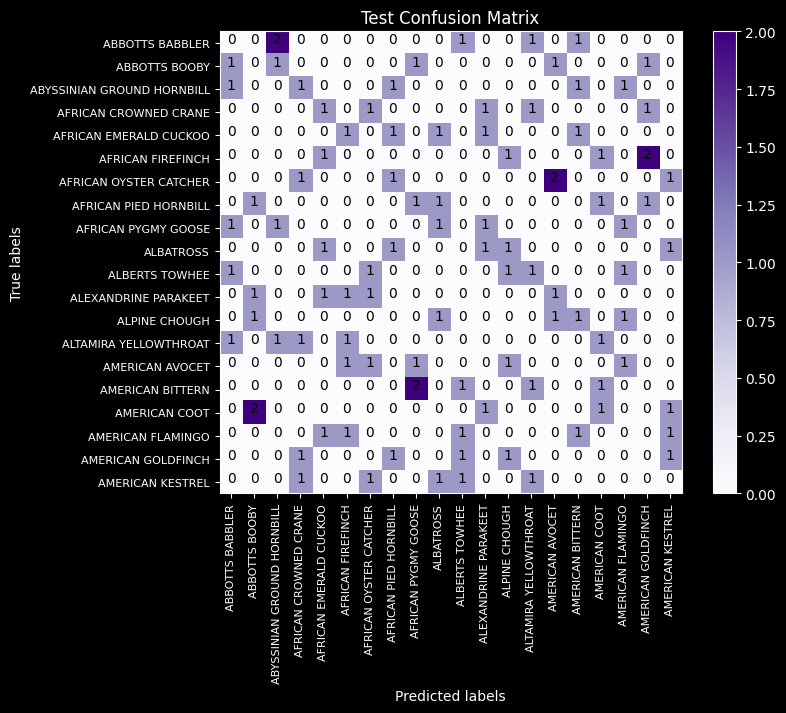

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
import tensorflow as tf

# Evaluate the model on the test dataset
test_loss, test_accuracy = resnet50_model.evaluate(test_ds)

print("Test Loss:", test_loss)  # Print test loss here
print("Test Accuracy:", test_accuracy)

# Predict labels for the test dataset
predictions = resnet50_model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels for the test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Compute additional metrics
f1 = f1_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix , cmap=plt.cm.Purples)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(len(class_names)), class_names, rotation=90 , fontsize=8)
plt.yticks(np.arange(len(class_names)), class_names , fontsize=8)
plt.colorbar()

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", fontsize = 10 , color="black")

plt.title("Test Confusion Matrix")
plt.show()


4/4 [==============================] - 6s 1s/step - loss: 0.0357 - accuracy: 1.0000
Test Loss: 0.035729676485061646
Test Accuracy: 1.0
4/4 [==============================] - 6s 1s/step
Classification Report:
                            precision    recall  f1-score   support

           ABBOTTS BABBLER       0.20      0.20      0.20         5
             ABBOTTS BOOBY       0.20      0.20      0.20         5
ABYSSINIAN GROUND HORNBILL       0.00      0.00      0.00         5
     AFRICAN CROWNED CRANE       0.00      0.00      0.00         5
    AFRICAN EMERALD CUCKOO       0.20      0.20      0.20         5
         AFRICAN FIREFINCH       0.00      0.00      0.00         5
    AFRICAN OYSTER CATCHER       0.00      0.00      0.00         5
     AFRICAN PIED HORNBILL       0.00      0.00      0.00         5
       AFRICAN PYGMY GOOSE       0.00      0.00      0.00         5
                 ALBATROSS       0.00      0.00      0.00         5
            ALBERTS TOWHEE       0.20      

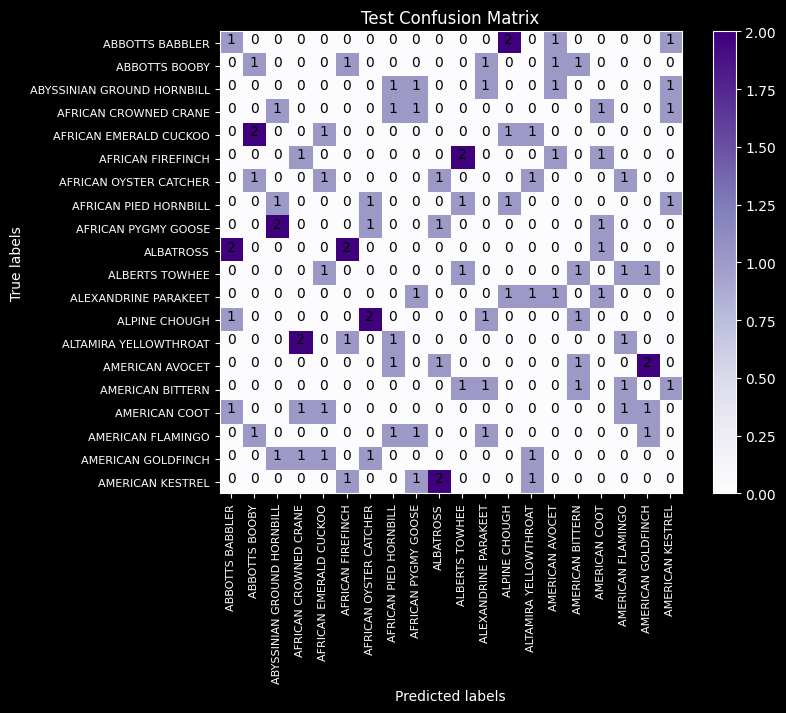

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# Evaluate the model on the test dataset
test_loss, test_accuracy = resnet50_model.evaluate(test_ds)

print("Test Loss:", test_loss)  # Print test loss here
print("Test Accuracy:", test_accuracy)

# Predict labels for the test dataset
predictions = resnet50_model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels for the test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Generate classification report

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix , cmap=plt.cm.Purples)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(len(class_names)), class_names, rotation=90 , fontsize=8)
plt.yticks(np.arange(len(class_names)), class_names , fontsize=8)
plt.colorbar()

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", fontsize=10 , color="black")

plt.title("Test Confusion Matrix")
plt.show()


# Ploting Model Accuracy and loss curves


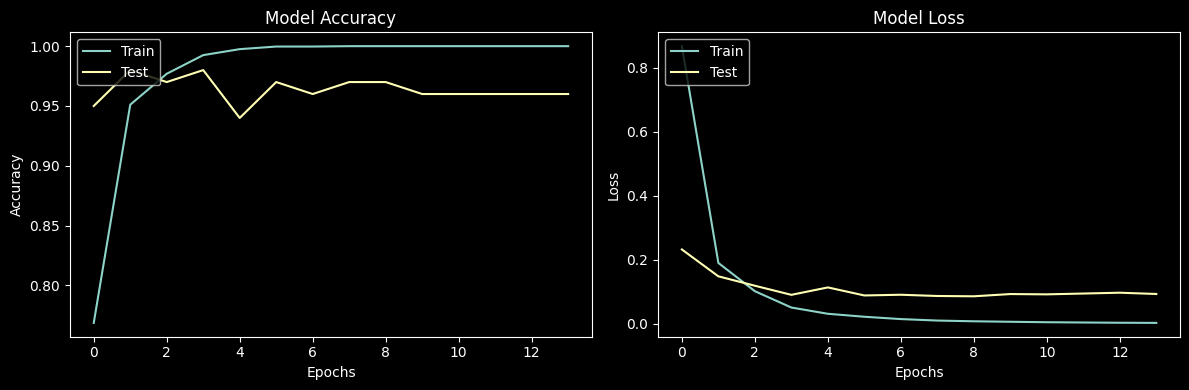

In [48]:
import matplotlib.pyplot as plt

# Plotting model accuracy and loss for both training and test data
plt.figure(figsize=(12, 4))

# Plotting model accuracy
plt.subplot(1, 2, 1)
plt.plot(RESMODEL.history['accuracy'])
plt.plot(RESMODEL.history['val_accuracy'])  # Adding validation accuracy
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting model loss
plt.subplot(1, 2, 2)
plt.plot(RESMODEL.history['loss'])
plt.plot(RESMODEL.history['val_loss'])  # Adding validation loss
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


# Testing The Model

first image to predict
actual label: ABYSSINIAN GROUND HORNBILL
1/1 [==============================] - 2s 2s/step
predicted label: ABYSSINIAN GROUND HORNBILL


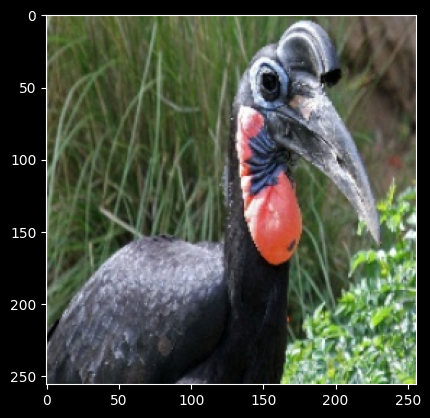

In [49]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = resnet50_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [50]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 109ms/step


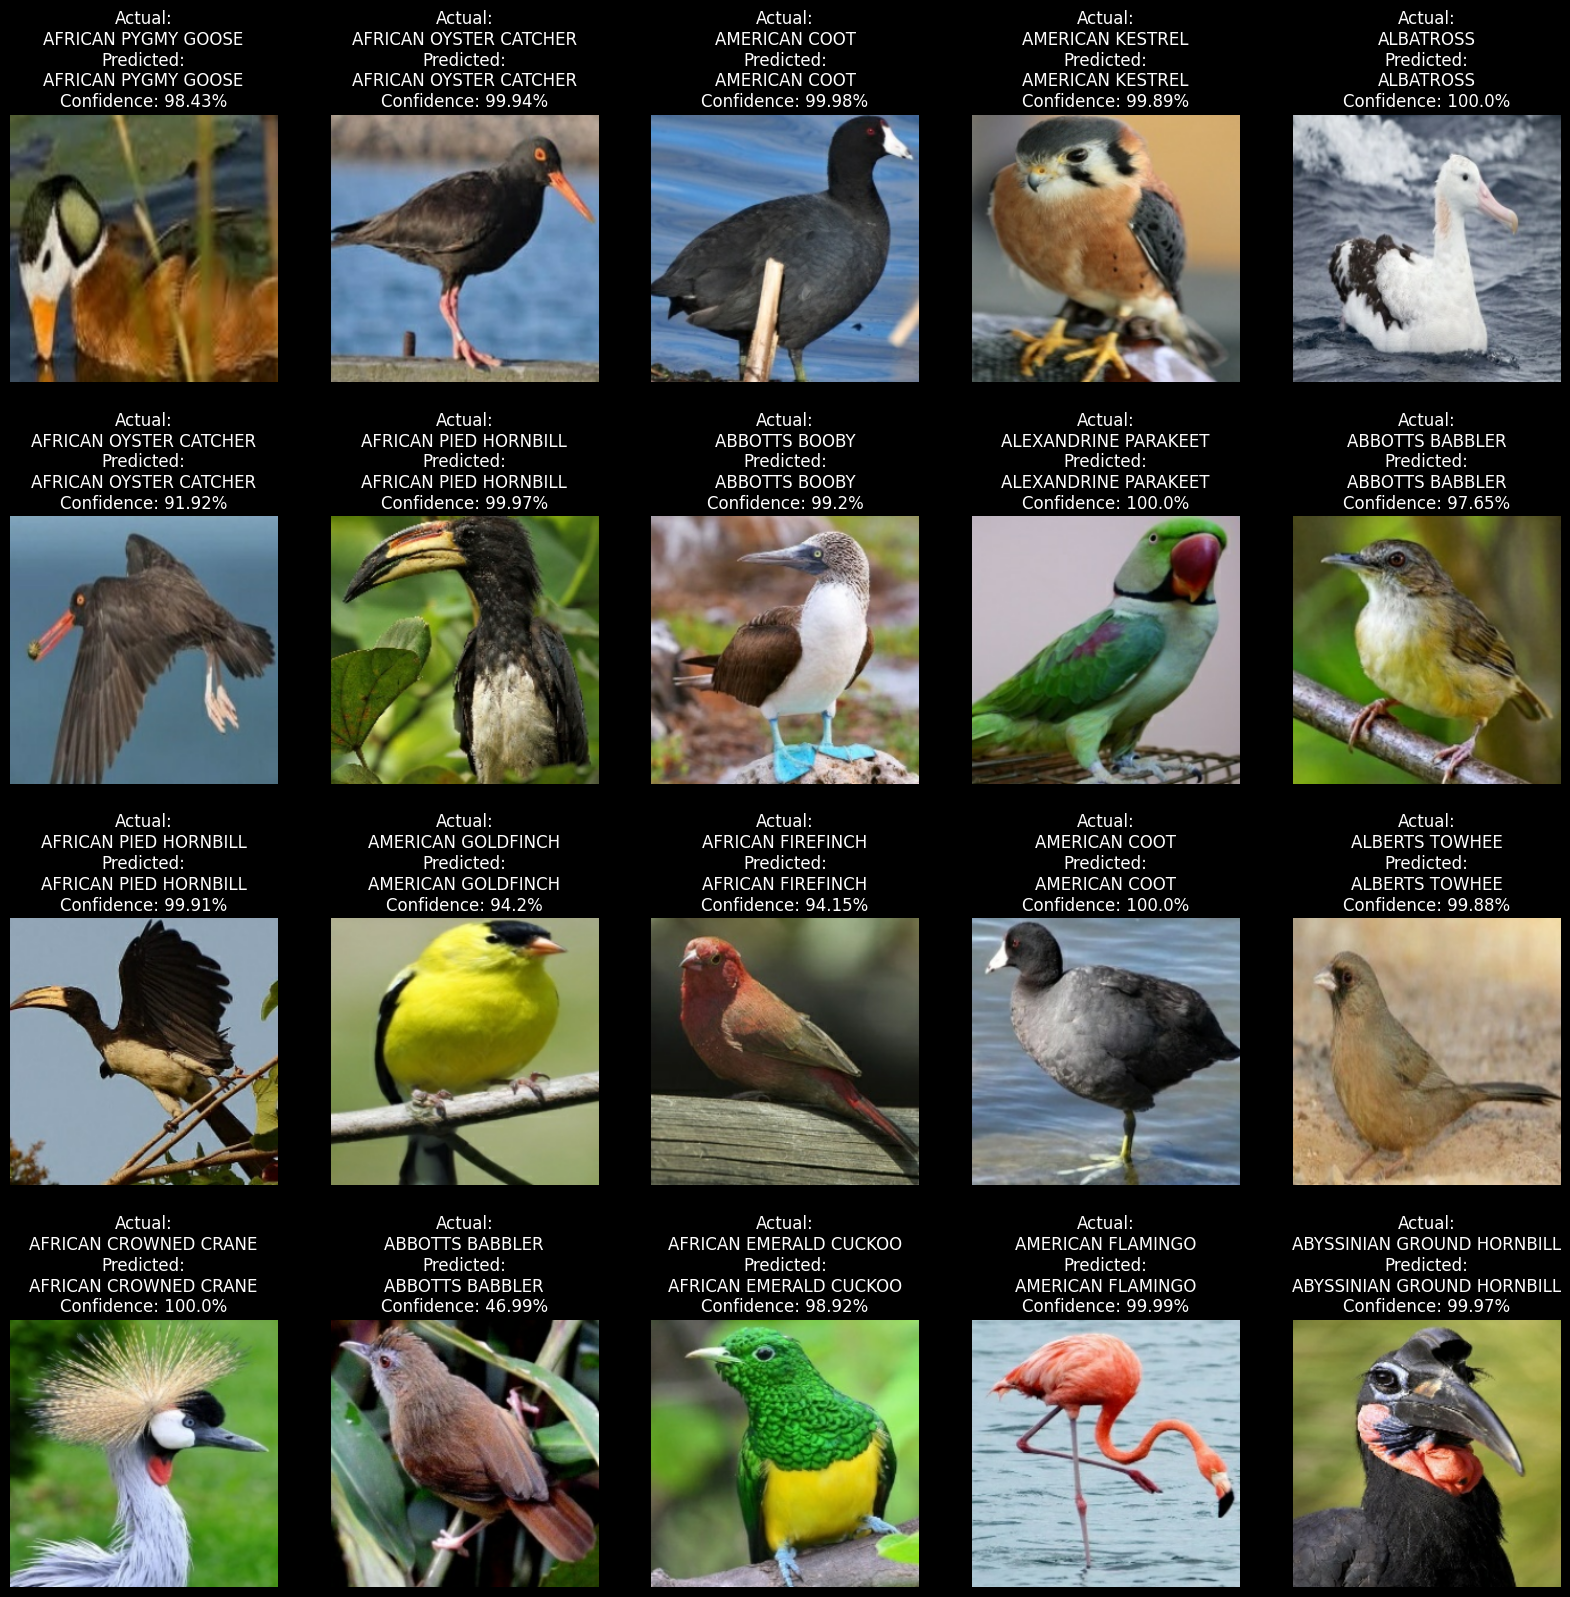

In [51]:
plt.figure(figsize=(20, 20))  # Adjusted figsize for a 4x5 grid
for images, labels in test_ds.take(1):
    for i in range(20):  # 4x5 grid, so 20 images
        ax = plt.subplot(4, 5, i + 1)  # 4 rows, 5 columns
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(resnet50_model, images[i].numpy())  # Assuming you have a predict function
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual:\n{actual_class}\nPredicted:\n{predicted_class}\nConfidence: {confidence}%")  # Displaying actual and predicted classes on separate lines
        
        plt.axis("off")
